# Libraries and Helper Functions

In [55]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import numpy as np

# Dataset and DataLoader Preparation

In [56]:
def load_data(images_dir, labels_file, class_to_idx):
    data = []
    labels_df = pd.read_csv(labels_file)
    for _, row in labels_df.iterrows():
        img_path = os.path.join(images_dir, f"{row.iloc[0]}.png") 
        label = class_to_idx[row.iloc[1]]  
        data.append((img_path, label))
    return data

In [57]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  
        if self.transform:
            image = self.transform(image)  
        return image, torch.tensor(label)


transform_no_norm = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor() 
])

class_to_idx = {'deer': 0, 'frog': 1, 'truck': 2}

train_data = load_data('train', 'train/trainLabels.csv', class_to_idx)
dev_data = load_data('dev', 'dev/devLabels.csv', class_to_idx)
test_data = load_data('test', 'test/testLabels.csv', class_to_idx)

train_dataset = ImageDataset(train_data, transform=transform_no_norm)
dev_dataset = ImageDataset(dev_data, transform=transform_no_norm)
test_dataset = ImageDataset(test_data, transform=transform_no_norm)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Compute Mean and Standard Deviation

In [58]:
def compute_mean_std(loader): 
    mean = 0.0
    std = 0.0
    total_images = 0

    for inputs, _ in loader:
        batch_samples = inputs.size(0)
        inputs = inputs.view(batch_samples, inputs.size(1), -1) 
        mean += inputs.mean(2).sum(0)
        std += inputs.std(2).sum(0)
        total_images += batch_samples 

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = compute_mean_std(train_loader)
print(f"Mean: {mean}, Std: {std}")


Mean: tensor([0.4785, 0.4623, 0.3972]), Std: tensor([0.1999, 0.1952, 0.1901])


# Reload Datasets with Normalization

In [59]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=mean, std=std)  
])

train_dataset = ImageDataset(train_data, transform=transform)
dev_dataset = ImageDataset(dev_data, transform=transform)
test_dataset = ImageDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the CNN Model

In [60]:
class SimpleCNN(nn.Module):
    def __init__(self, 
                 conv_filters=[16, 32, 64], 
                 dropout_fc=0.0, 
                 dropout_conv=0.0, 
                 pooling_config=('max', 'avg'),
                 fc_config=[128], 
                 activation='relu'):
        super(SimpleCNN, self).__init__()  
        
        self.activation_fn = self.get_activation_function(activation)

        self.conv1 = nn.Conv2d(3, conv_filters[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=3, padding=1)
        
        self.dropout_conv = nn.Dropout(dropout_conv)

        self.pool1 = self.get_pooling_layer(pooling_config[0])
        self.pool2 = self.get_pooling_layer(pooling_config[1])

        self.fc_layers = nn.Sequential(  
            nn.Linear(conv_filters[2] * 8 * 8, fc_config[0]),  
            self.activation_fn,
            nn.Dropout(dropout_fc),
            nn.Linear(fc_config[0], 3)  
        )

    def get_pooling_layer(self, pool_type):
        if pool_type == 'max':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool_type == 'avg':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise ValueError("Unsupported pooling type")

    def get_activation_function(self, activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.dropout_conv(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool1(x)
        x = self.activation_fn(self.conv3(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)  
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)


# Define Training and Testing Functions

In [71]:
def train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=20):
    train_accuracies = []
    dev_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total

        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        model.eval()
        dev_correct_predictions = 0
        dev_total = 0
        dev_loss = 0.0

        with torch.no_grad():
            for inputs, labels in dev_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                dev_total += labels.size(0)
                dev_correct_predictions += (predicted == labels).sum().item()

        dev_loss /= len(dev_loader)
        dev_acc = dev_correct_predictions / dev_total

        dev_accuracies.append(dev_acc)

        print(f"Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}")
    
    avg_train_acc = sum(train_accuracies) / len(train_accuracies)
    avg_dev_acc = sum(dev_accuracies) / len(dev_accuracies)

    print(f"\nAverage Training Accuracy over all epochs: {avg_train_acc:.4f}")
    print(f"Average Validation Accuracy over all epochs: {avg_dev_acc:.4f}")

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [72]:
model = SimpleCNN(conv_filters=[16, 32, 64], dropout_fc=0.0, pooling_config=('max', 'avg'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs= 30)

test_model(model, test_loader)


Epoch 1/30, Loss: 1.0243, Training Accuracy: 0.4728
Validation Loss: 0.8847, Validation Accuracy: 0.6377
Epoch 2/30, Loss: 0.9248, Training Accuracy: 0.5946
Validation Loss: 0.8851, Validation Accuracy: 0.5870
Epoch 3/30, Loss: 0.8923, Training Accuracy: 0.6314
Validation Loss: 0.8236, Validation Accuracy: 0.6739
Epoch 4/30, Loss: 0.8499, Training Accuracy: 0.6907
Validation Loss: 0.8223, Validation Accuracy: 0.6884
Epoch 5/30, Loss: 0.8298, Training Accuracy: 0.7244
Validation Loss: 0.8038, Validation Accuracy: 0.7246
Epoch 6/30, Loss: 0.8157, Training Accuracy: 0.7324
Validation Loss: 0.7770, Validation Accuracy: 0.7319
Epoch 7/30, Loss: 0.7950, Training Accuracy: 0.7516
Validation Loss: 0.7701, Validation Accuracy: 0.7464
Epoch 8/30, Loss: 0.8016, Training Accuracy: 0.7484
Validation Loss: 0.8463, Validation Accuracy: 0.6739
Epoch 9/30, Loss: 0.7978, Training Accuracy: 0.7580
Validation Loss: 0.7741, Validation Accuracy: 0.7246
Epoch 10/30, Loss: 0.7838, Training Accuracy: 0.7708
Va

75.15527950310559

# -------------------- Q1 --------------------

In [73]:
# I explained it in the report

# -------------------- Q2 --------------------

In [76]:
model1 = SimpleCNN(dropout_fc=0.5, dropout_conv=0.0)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

train_model(model1, train_loader, dev_loader, criterion1, optimizer1, num_epochs=30)
test_model(model1, test_loader)


model2 = SimpleCNN(dropout_fc=0.3, dropout_conv=0.0)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion2 = nn.CrossEntropyLoss()

train_model(model2, train_loader, dev_loader, criterion2, optimizer2, num_epochs=30)
test_model(model2, test_loader)


model3 = SimpleCNN(dropout_fc=0.0, dropout_conv=0.3)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
criterion3 = nn.CrossEntropyLoss()

train_model(model3, train_loader, dev_loader, criterion3, optimizer3, num_epochs=30)
test_model(model3, test_loader)


model4 = SimpleCNN(dropout_fc=0.0, dropout_conv=0.5)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
criterion4 = nn.CrossEntropyLoss()

train_model(model4, train_loader, dev_loader, criterion4, optimizer4, num_epochs=30)
test_model(model4, test_loader)


model5 = SimpleCNN(dropout_fc=0.0, dropout_conv=0.0)
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)
criterion5 = nn.CrossEntropyLoss()

train_model(model5, train_loader, dev_loader, criterion5, optimizer5, num_epochs=30)
test_model(model5, test_loader)


Epoch 1/30, Loss: 1.0477, Training Accuracy: 0.4423
Validation Loss: 0.9161, Validation Accuracy: 0.5725
Epoch 2/30, Loss: 0.9522, Training Accuracy: 0.5705
Validation Loss: 0.8993, Validation Accuracy: 0.5870
Epoch 3/30, Loss: 0.9426, Training Accuracy: 0.6074
Validation Loss: 0.8868, Validation Accuracy: 0.5797
Epoch 4/30, Loss: 0.9077, Training Accuracy: 0.6170
Validation Loss: 0.8501, Validation Accuracy: 0.6522
Epoch 5/30, Loss: 0.8972, Training Accuracy: 0.6490
Validation Loss: 0.8452, Validation Accuracy: 0.6449
Epoch 6/30, Loss: 0.8749, Training Accuracy: 0.6731
Validation Loss: 0.8026, Validation Accuracy: 0.6884
Epoch 7/30, Loss: 0.8482, Training Accuracy: 0.6891
Validation Loss: 0.8227, Validation Accuracy: 0.6522
Epoch 8/30, Loss: 0.8466, Training Accuracy: 0.6923
Validation Loss: 0.7631, Validation Accuracy: 0.7319
Epoch 9/30, Loss: 0.8357, Training Accuracy: 0.7163
Validation Loss: 0.7760, Validation Accuracy: 0.7101
Epoch 10/30, Loss: 0.8366, Training Accuracy: 0.7067
Va

74.53416149068323

# ----------------- Q3 ------------------

In [86]:
filter_configs = [
    [16, 16, 16],  
    [64, 32, 16]   
]

for filters in filter_configs:
    model = SimpleCNN(conv_filters=filters,dropout_fc=0.0, dropout_conv=0.3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=30)
    test_model(model, test_loader)


Epoch 1/30, Loss: 1.0703, Training Accuracy: 0.3958
Validation Loss: 0.9824, Validation Accuracy: 0.5580
Epoch 2/30, Loss: 0.9781, Training Accuracy: 0.5433
Validation Loss: 0.9021, Validation Accuracy: 0.5797
Epoch 3/30, Loss: 0.9373, Training Accuracy: 0.5962
Validation Loss: 0.8584, Validation Accuracy: 0.6304
Epoch 4/30, Loss: 0.9060, Training Accuracy: 0.6330
Validation Loss: 0.8336, Validation Accuracy: 0.6667
Epoch 5/30, Loss: 0.8765, Training Accuracy: 0.6554
Validation Loss: 0.8452, Validation Accuracy: 0.6377
Epoch 6/30, Loss: 0.8513, Training Accuracy: 0.6875
Validation Loss: 0.8098, Validation Accuracy: 0.6957
Epoch 7/30, Loss: 0.8317, Training Accuracy: 0.7147
Validation Loss: 0.8017, Validation Accuracy: 0.6884
Epoch 8/30, Loss: 0.8123, Training Accuracy: 0.7436
Validation Loss: 0.7934, Validation Accuracy: 0.6739
Epoch 9/30, Loss: 0.8061, Training Accuracy: 0.7356
Validation Loss: 0.7919, Validation Accuracy: 0.6739
Epoch 10/30, Loss: 0.7905, Training Accuracy: 0.7516
Va

# ------------------ Q4 ------------------

In [87]:
pooling_configs = [
    ('max', 'max'),  
    ('avg', 'max'),  
    ('avg', 'avg')   
]

for pooling in pooling_configs:
    model = SimpleCNN(pooling_config=pooling,dropout_fc=0.0, dropout_conv=0.3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=30)
    test_model(model, test_loader)


Epoch 1/30, Loss: 1.0178, Training Accuracy: 0.4776
Validation Loss: 0.8811, Validation Accuracy: 0.6232
Epoch 2/30, Loss: 0.9357, Training Accuracy: 0.5881
Validation Loss: 0.8608, Validation Accuracy: 0.6087
Epoch 3/30, Loss: 0.8791, Training Accuracy: 0.6522
Validation Loss: 0.8375, Validation Accuracy: 0.6522
Epoch 4/30, Loss: 0.8403, Training Accuracy: 0.7099
Validation Loss: 0.7893, Validation Accuracy: 0.7029
Epoch 5/30, Loss: 0.8192, Training Accuracy: 0.7340
Validation Loss: 0.7889, Validation Accuracy: 0.6739
Epoch 6/30, Loss: 0.8055, Training Accuracy: 0.7516
Validation Loss: 0.7933, Validation Accuracy: 0.6594
Epoch 7/30, Loss: 0.7793, Training Accuracy: 0.7628
Validation Loss: 0.7609, Validation Accuracy: 0.7029
Epoch 8/30, Loss: 0.7649, Training Accuracy: 0.7853
Validation Loss: 0.7701, Validation Accuracy: 0.6884
Epoch 9/30, Loss: 0.7688, Training Accuracy: 0.7853
Validation Loss: 0.7675, Validation Accuracy: 0.6812
Epoch 10/30, Loss: 0.7737, Training Accuracy: 0.7708
Va

# ----------------- Q5 --------------------

In [96]:
fc_configs = [
    [50],             
    [128, 64]         
]

for fc_config in fc_configs:
    model = SimpleCNN(fc_config=fc_config,dropout_fc=0.0, dropout_conv=0.3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=30)
    test_model(model, test_loader)


Epoch 1/30, Loss: 1.0829, Training Accuracy: 0.4279
Validation Loss: 1.0124, Validation Accuracy: 0.5797
Epoch 2/30, Loss: 0.9606, Training Accuracy: 0.5705
Validation Loss: 0.8762, Validation Accuracy: 0.6232
Epoch 3/30, Loss: 0.9288, Training Accuracy: 0.6010
Validation Loss: 0.8664, Validation Accuracy: 0.6159
Epoch 4/30, Loss: 0.8953, Training Accuracy: 0.6378
Validation Loss: 0.8412, Validation Accuracy: 0.6594
Epoch 5/30, Loss: 0.8627, Training Accuracy: 0.6747
Validation Loss: 0.8104, Validation Accuracy: 0.6667
Epoch 6/30, Loss: 0.8451, Training Accuracy: 0.7083
Validation Loss: 0.8048, Validation Accuracy: 0.7101
Epoch 7/30, Loss: 0.8317, Training Accuracy: 0.7276
Validation Loss: 0.7731, Validation Accuracy: 0.7319
Epoch 8/30, Loss: 0.8136, Training Accuracy: 0.7436
Validation Loss: 0.7510, Validation Accuracy: 0.7464
Epoch 9/30, Loss: 0.7994, Training Accuracy: 0.7564
Validation Loss: 0.7781, Validation Accuracy: 0.7246
Epoch 10/30, Loss: 0.7801, Training Accuracy: 0.7756
Va

# ----------------- Q6 -------------------

In [99]:
activations = ['tanh', 'relu']

for activation in activations:
    model = SimpleCNN(activation=activation,dropout_fc=0.0, dropout_conv=0.3,fc_config=[50])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=30)
    test_model(model, test_loader)


Epoch 1/30, Loss: 0.9896, Training Accuracy: 0.5080
Validation Loss: 0.8876, Validation Accuracy: 0.6377
Epoch 2/30, Loss: 0.9005, Training Accuracy: 0.6442
Validation Loss: 0.8287, Validation Accuracy: 0.6812
Epoch 3/30, Loss: 0.8596, Training Accuracy: 0.6907
Validation Loss: 0.8039, Validation Accuracy: 0.6957
Epoch 4/30, Loss: 0.8270, Training Accuracy: 0.7404
Validation Loss: 0.8102, Validation Accuracy: 0.6739
Epoch 5/30, Loss: 0.8092, Training Accuracy: 0.7516
Validation Loss: 0.7897, Validation Accuracy: 0.6884
Epoch 6/30, Loss: 0.8010, Training Accuracy: 0.7548
Validation Loss: 0.7837, Validation Accuracy: 0.7029
Epoch 7/30, Loss: 0.7749, Training Accuracy: 0.7885
Validation Loss: 0.7781, Validation Accuracy: 0.7101
Epoch 8/30, Loss: 0.7778, Training Accuracy: 0.7885
Validation Loss: 0.7835, Validation Accuracy: 0.6957
Epoch 9/30, Loss: 0.7653, Training Accuracy: 0.7965
Validation Loss: 0.7520, Validation Accuracy: 0.7464
Epoch 10/30, Loss: 0.7416, Training Accuracy: 0.8173
Va

# --------------------- Q7 --------------------

In [112]:
model = SimpleCNN(conv_filters=[16, 32, 64], dropout_fc=0.0, dropout_conv=0.3, pooling_config=('max', 'avg'),fc_config=[50])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs= 30)

test_model(model, test_loader)


Epoch 1/30, Loss: 1.0745, Training Accuracy: 0.4151
Validation Loss: 0.9835, Validation Accuracy: 0.5000
Epoch 2/30, Loss: 0.9699, Training Accuracy: 0.5369
Validation Loss: 0.8674, Validation Accuracy: 0.6159
Epoch 3/30, Loss: 0.9077, Training Accuracy: 0.6202
Validation Loss: 0.8479, Validation Accuracy: 0.6377
Epoch 4/30, Loss: 0.8685, Training Accuracy: 0.6875
Validation Loss: 0.8920, Validation Accuracy: 0.6014
Epoch 5/30, Loss: 0.8893, Training Accuracy: 0.6314
Validation Loss: 0.8075, Validation Accuracy: 0.6667
Epoch 6/30, Loss: 0.8377, Training Accuracy: 0.7163
Validation Loss: 0.7806, Validation Accuracy: 0.7029
Epoch 7/30, Loss: 0.8236, Training Accuracy: 0.7308
Validation Loss: 0.7755, Validation Accuracy: 0.7101
Epoch 8/30, Loss: 0.8133, Training Accuracy: 0.7292
Validation Loss: 0.7686, Validation Accuracy: 0.7246
Epoch 9/30, Loss: 0.7811, Training Accuracy: 0.7708
Validation Loss: 0.7572, Validation Accuracy: 0.7246
Epoch 10/30, Loss: 0.7793, Training Accuracy: 0.7740
Va

73.29192546583852

In [113]:
def visualize_feature_maps(model, test_loader, layer_names, num_images=4):

    model.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)  

    outputs = {}
    hooks = []

    for name, layer in model.named_modules():
        if name in layer_names:
            def hook_fn(name):
                return lambda m, i, o: outputs.update({name: o})
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    for img_idx in range(num_images):
        plt.figure(figsize=(20, 10))

        original_img = images[img_idx].cpu().permute(1, 2, 0).numpy()
        plt.subplot(len(layer_names) + 1, 8, 1)
        plt.imshow(original_img)
        plt.axis("off")
        plt.title("Original Image")

        for layer_idx, layer_name in enumerate(layer_names):
            if layer_name not in outputs:
                print(f"Feature map for layer {layer_name} not captured!")  
                continue

            feature_map = outputs[layer_name][img_idx].cpu().numpy()  
            num_features = feature_map.shape[0]  

            for feature_idx in range(min(8, num_features)):
                plt.subplot(len(layer_names) + 1, 8, (layer_idx + 1) * 8 + feature_idx + 1)
                plt.imshow(feature_map[feature_idx], cmap="viridis")
                plt.axis("off")
                plt.title(f"{layer_name}: {feature_idx}")

        plt.tight_layout()
        plt.show()


In [114]:
layer_names = ["conv1", "conv2", "conv3"] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


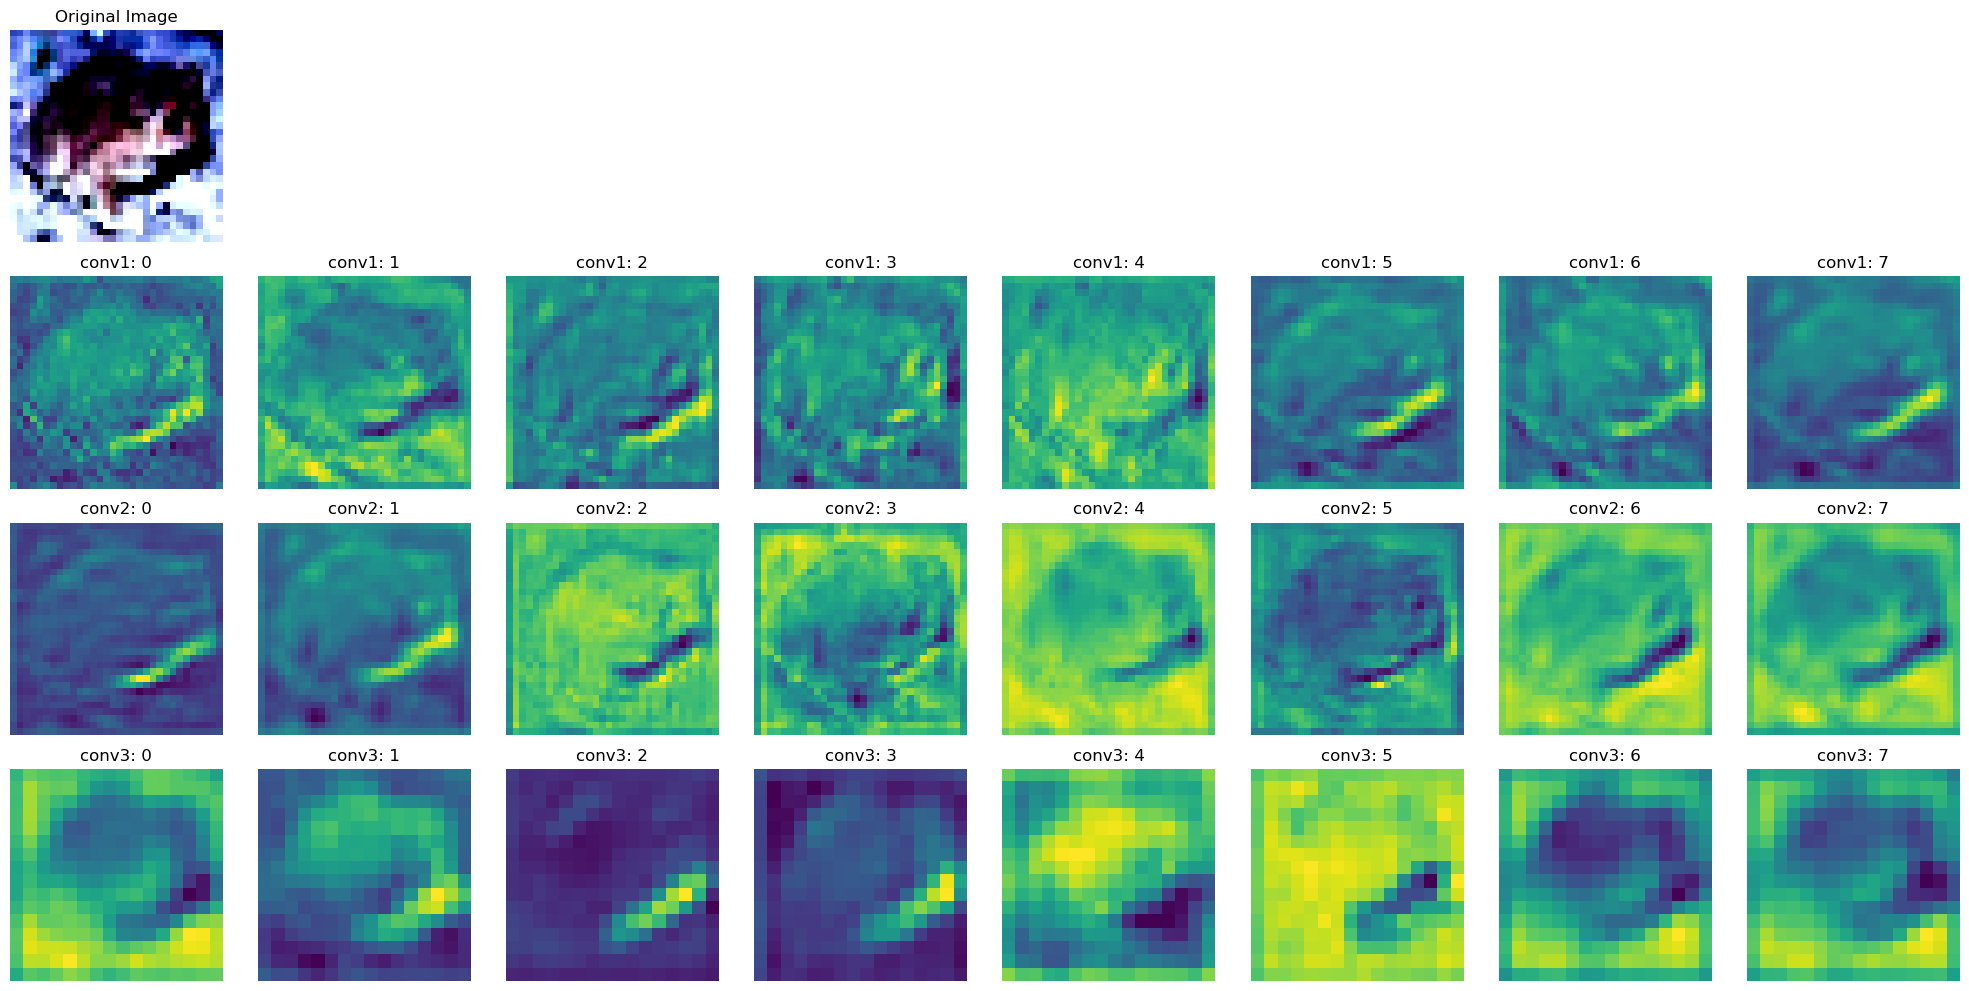

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


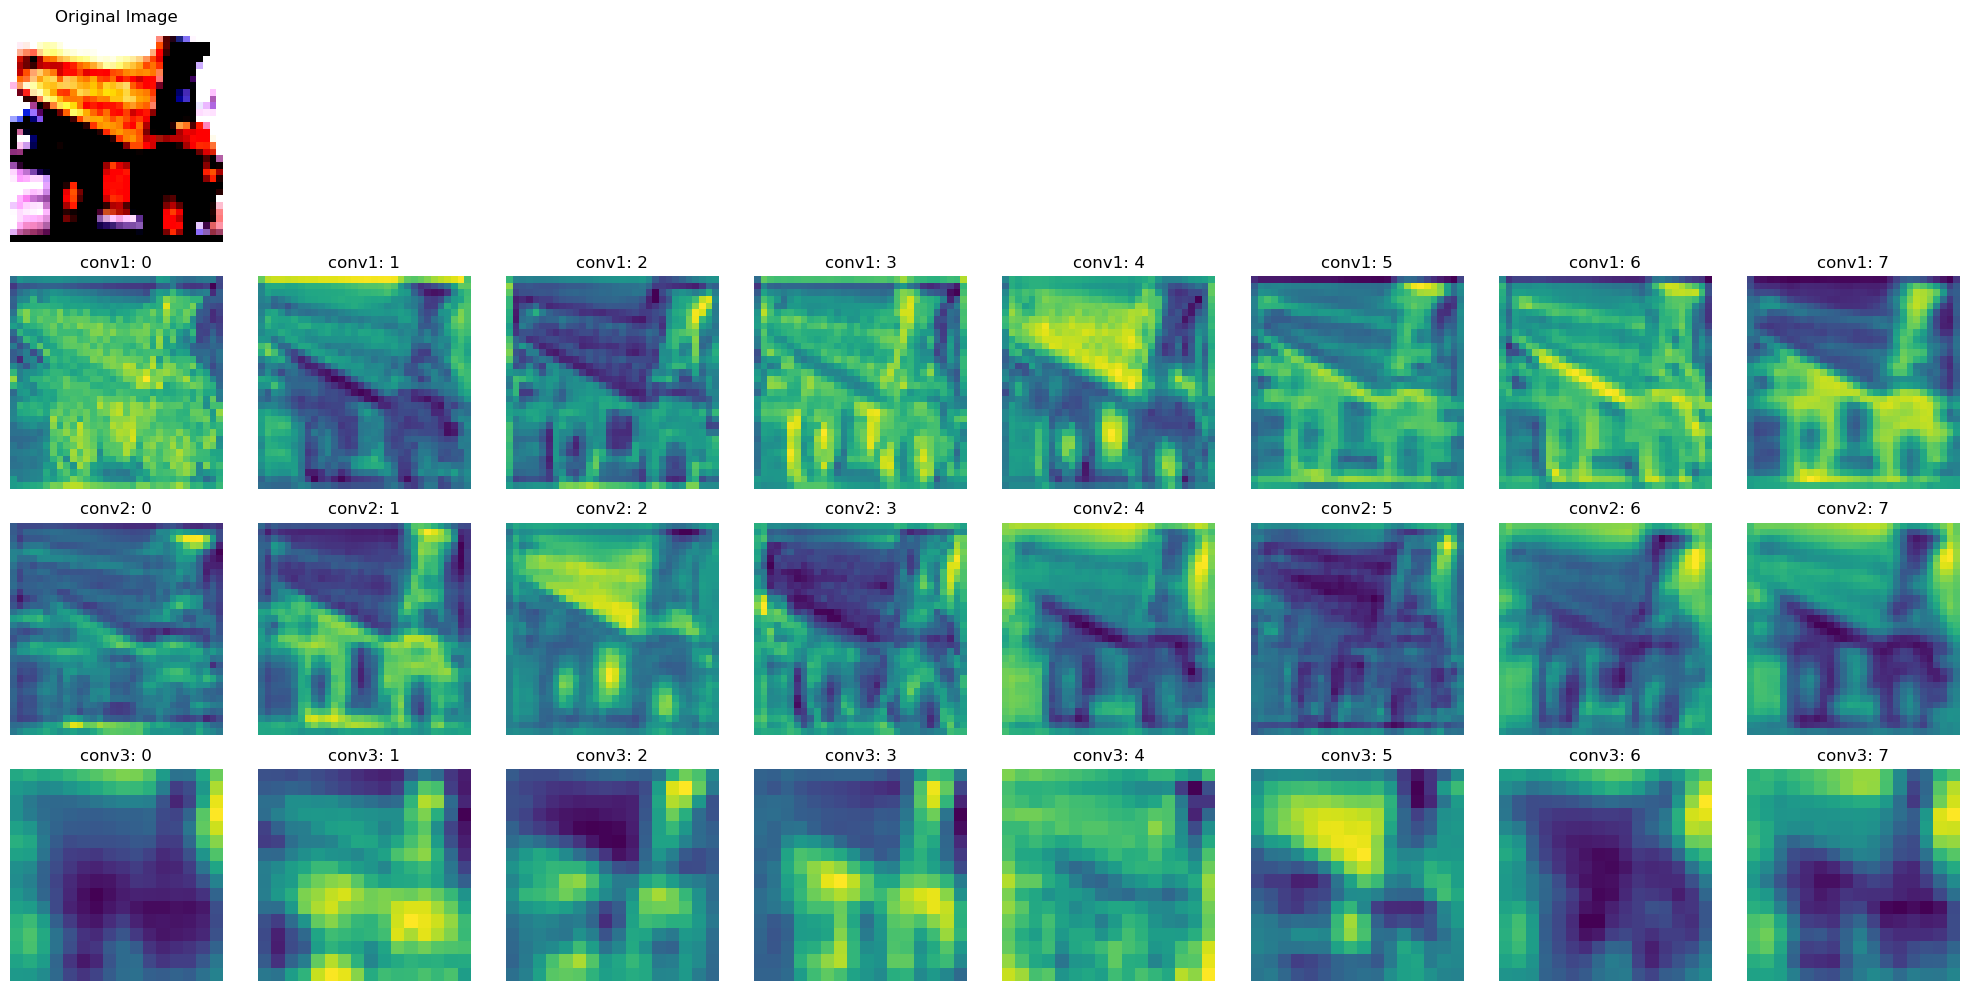

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


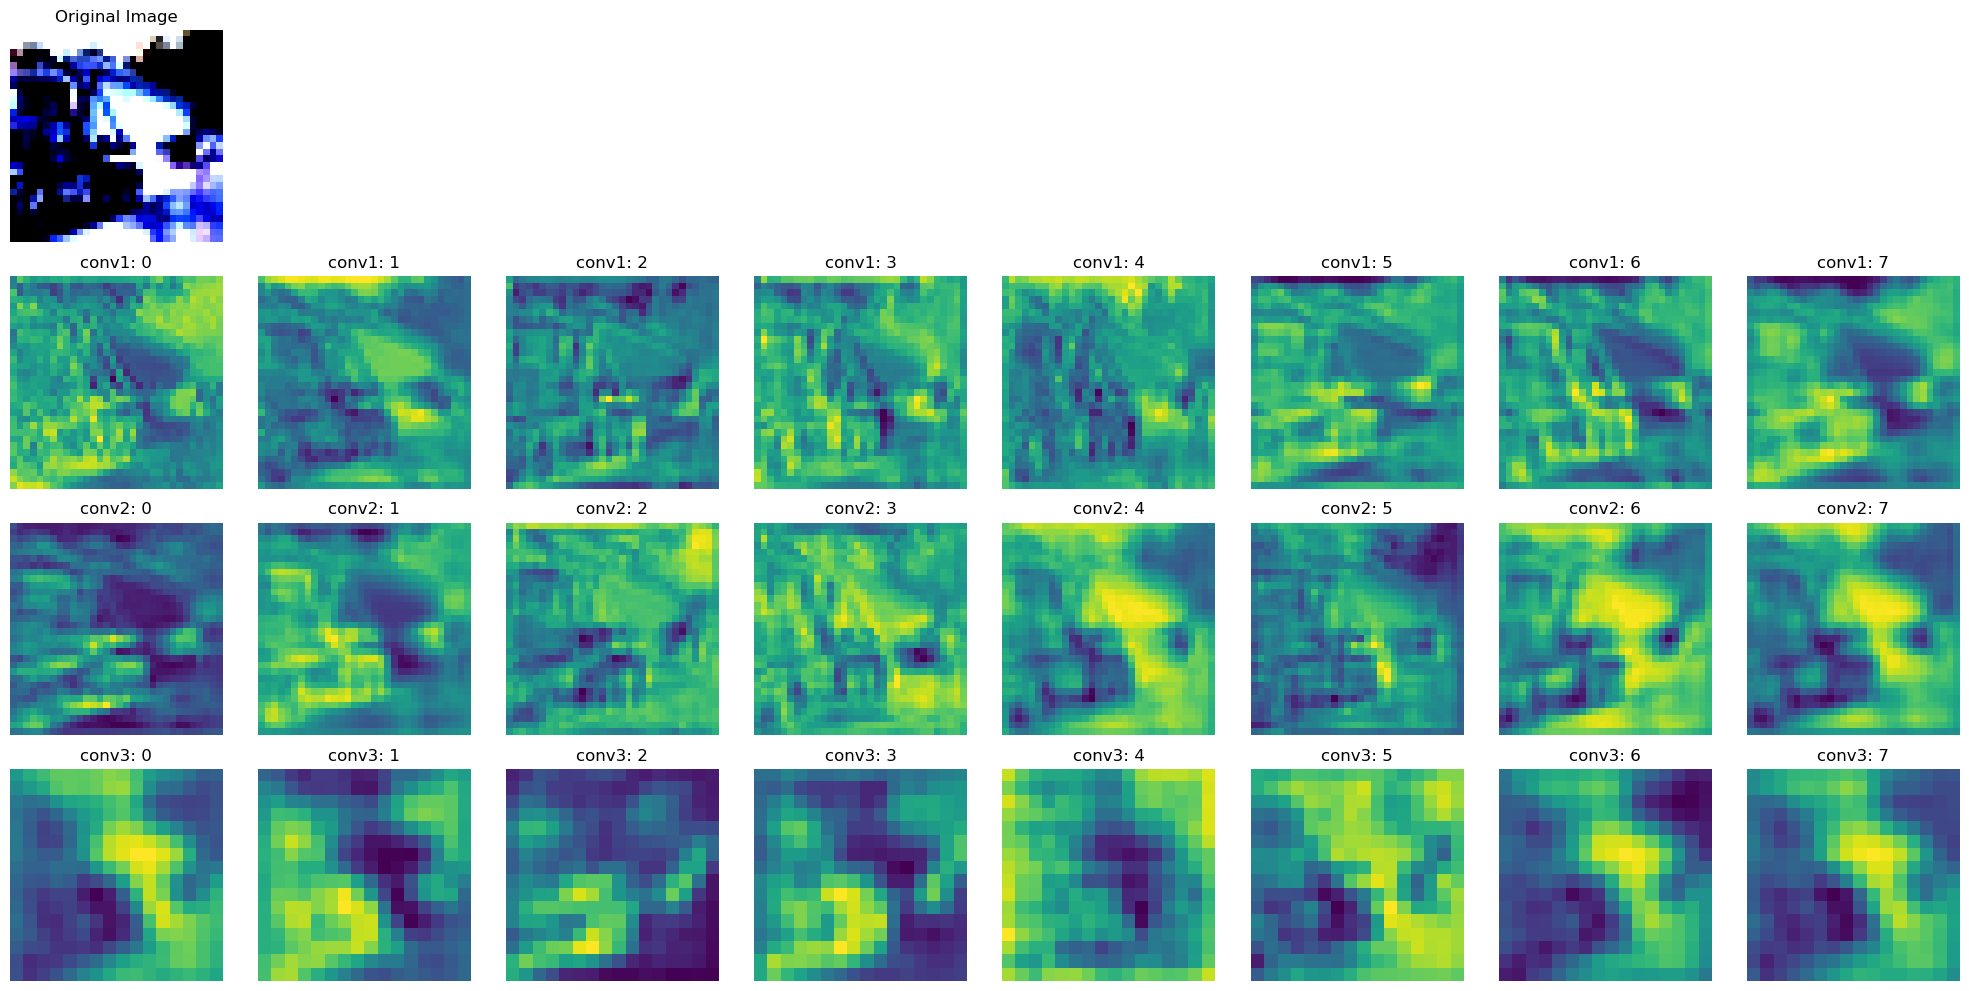

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


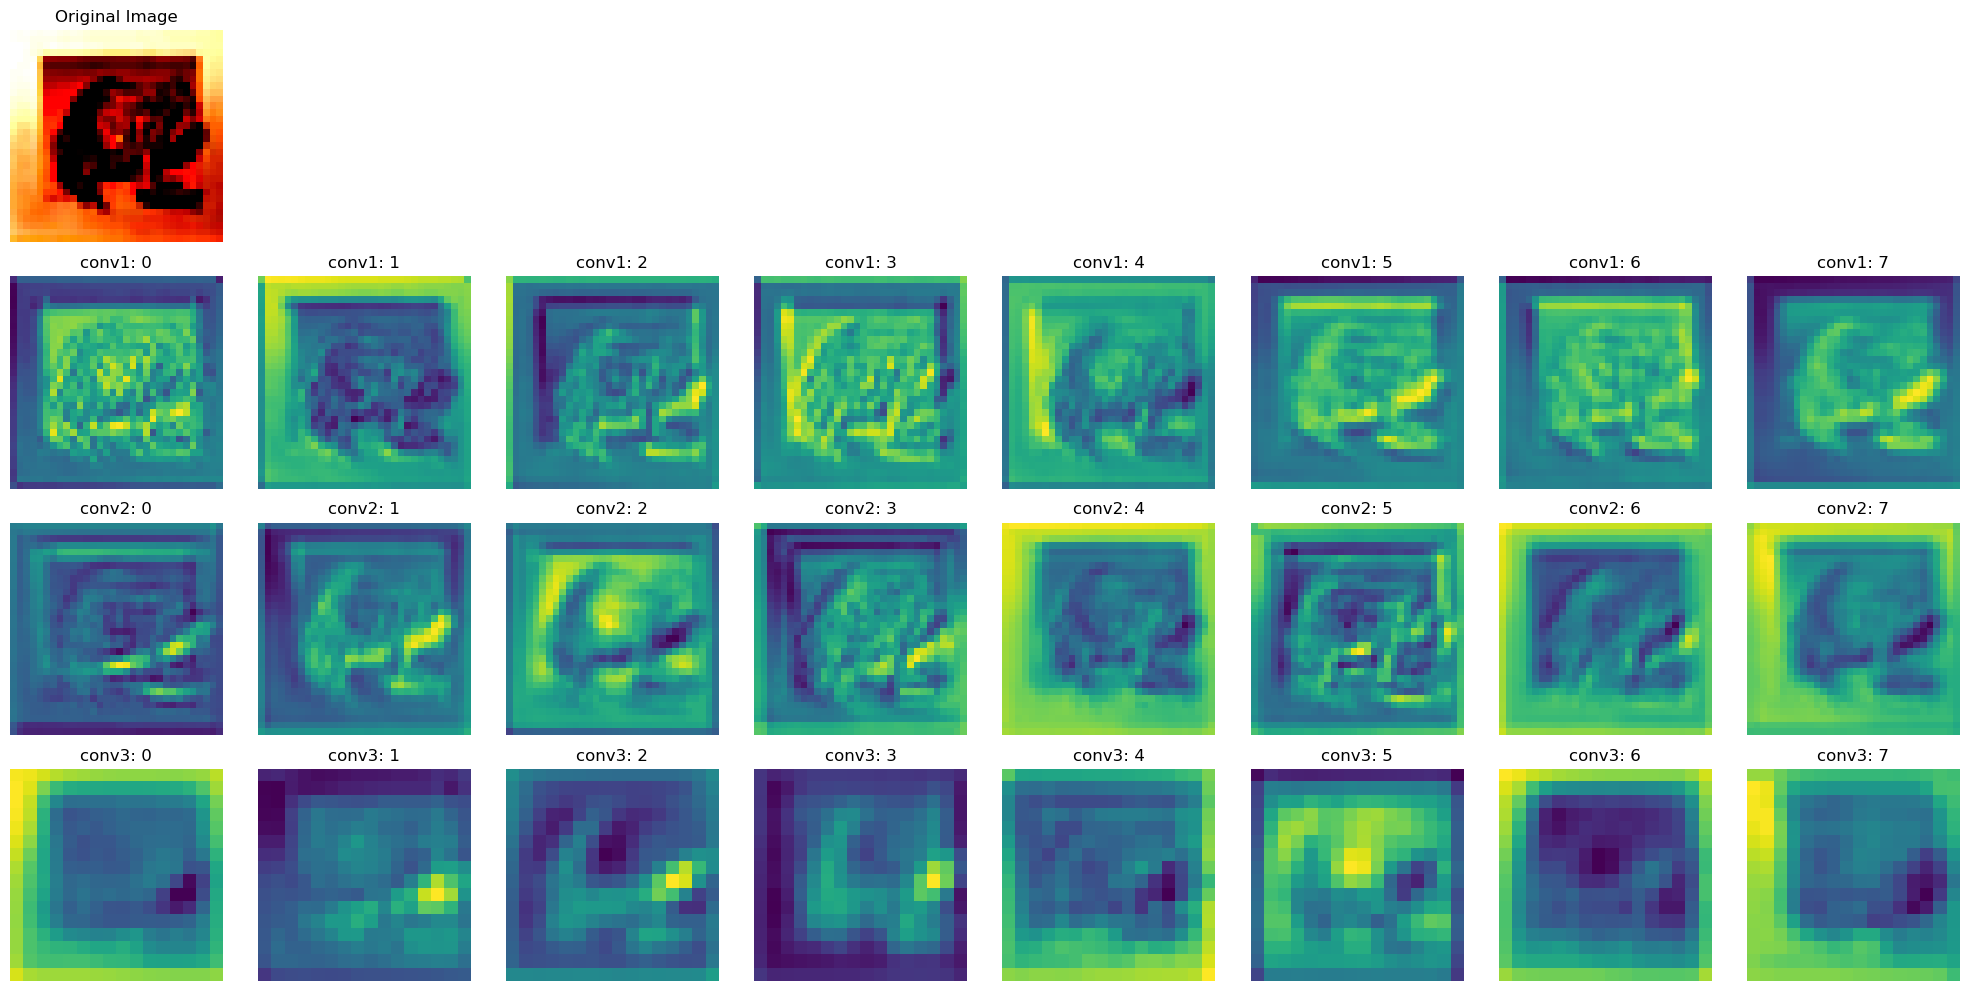

In [115]:
visualize_feature_maps(model, test_loader, layer_names=["conv1", "conv2", "conv3"], num_images=4)